# PyopenCL kernel for 3D CLAHE

I implement a pyopencl kernel to process 3D images with **CLAHE** (Contrast Limited Adaptive Histogram Equalization) with GPU acceleration. I compare the performances of the CPU clahe algorithm (skimage.exposure.equalize_adapthist) and my GPU adapted one on 3D organoid microscopy images. I also compare the results to verify that CPU and GPU versions of clahe produce similar equalization. To test it with your own data, add **8-bit** 3D stacks named "*raw.tif" to the /Images folder.

In [13]:
# import dependencies

import pyopencl as cl
import numpy as np
import os
import glob
import time
from skimage import io , exposure
import matplotlib.pyplot as plt

In [14]:
# specify main directory
main_dir = 'C:/Users/gerriadmin/Desktop/Morphology project Hugo/PIPELINE ONGOING/pyopencl_clahe/'

# specify subdirectories
img_dir = main_dir + 'Images/'

## GPU implementation

In [15]:
# run the GPU clah kernel 'clahe_3D_kernel.py'
os.chdir(main_dir)
%run clahe_3D_kernel.py

# Setup OpenCL environment (You might have to modify the platform and devices to use with GPU)
platform = cl.get_platforms()[1]
device = platform.get_devices()[0]
context = cl.Context([device])
queue = cl.CommandQueue(context)
program = cl.Program(context, clahe_3D_kernel).build()


mf = cl.mem_flags

print('Device:', device)

Device: <pyopencl.Device 'NVIDIA RTX A6000' on 'NVIDIA CUDA' at 0x283c089d090>


In [17]:
# Define CLAHE parameters
tile_size = 8
clip = 0.01 # top 1% of the histogram.

# get images
os.chdir(img_dir)
images = sorted(glob.glob('*raw.tif'))
image = images[:]
image=io.imread(images[0])


# find image size and computation time
img_size = []
time_gpu = []


for image in images:

    base = os.path.splitext(image)[0] # get image name
    img_np = np.array(io.imread(image)) # open image as 3D array
    shape , type = img_np.shape , img_np.dtype

    # adapt clip limit to image bit depth = 255
    if type == 'uint8':
        clip_limit = clip * 2**8
        bit_depth = 8
    else:
        print('Unrecognized bit depth')

    print("Current image: ", base)
    print("Image shape: ", shape)
    print("Image bit depth: ", bit_depth)

    depth, height, width = shape # get image dimensions and extremal intensities
    img_size.append(img_np.size)
    min_intensity = np.min(img_np)
    max_intensity = np.max(img_np)

    
    
    # Create OpenCL buffers
    img_buf = cl.Buffer(context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=img_np)
    result_buf = cl.Buffer(context, mf.WRITE_ONLY, img_np.nbytes)

    #initiate computation time
    t0 = time.time()

    # Execute the kernel
    global_size = (width, height, depth)
    program.clahe_3D(queue, global_size, None, img_buf, result_buf, 
                      np.int32(width), np.int32(height), np.int32(depth), np.int32(tile_size),
                      np.float32(clip_limit), np.float32(min_intensity), np.float32(max_intensity))
        
    # Retrieve the result
    result_np = np.empty_like(img_np)
    cl.enqueue_copy(queue, result_np, result_buf).wait()

    time_gpu.append(time.time()-t0)
    
    # save image
    io.imsave(img_dir+base.replace('_raw', '')+'_clahe_gpu.tif', result_np , check_contrast=False)

Current image:  Torg1_raw
Image shape:  (95, 795, 795)
Image bit depth:  8
Current image:  Torg2_raw
Image shape:  (110, 806, 804)
Image bit depth:  8
Current image:  Torg3_raw
Image shape:  (117, 806, 804)
Image bit depth:  8
Current image:  Torg4_raw
Image shape:  (130, 806, 804)
Image bit depth:  8
Current image:  Torg5_raw
Image shape:  (77, 512, 512)
Image bit depth:  8
Current image:  Torg6_raw
Image shape:  (127, 714, 712)
Image bit depth:  8


Text(0.5, 1.0, 'CLAHE GPU, tile size=8, clip limit=0.01')

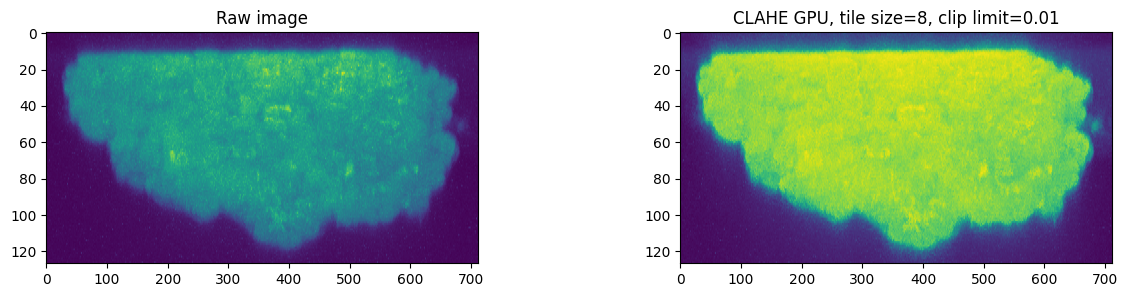

In [18]:
# visualize last processed image
fig,axs=plt.subplots(1,2,figsize=(15,3))
axs[0].imshow(np.max(img_np,axis=1),aspect=3)
axs[1].imshow(np.max(result_np,axis=1),aspect=3)
axs[0].set_title('Raw image')
axs[1].set_title('CLAHE GPU, tile size='+str(tile_size)+', clip limit='+str(clip))

## CPU implementation

In [19]:
time_cpu = []

for image in images:
    base = os.path.splitext(image)[0]
    img_np = io.imread(image).astype('uint8')
    print("Current image: ", base)
    print("image shape:", img_np.shape)

    t0 = time.time()
    equalized = exposure.equalize_adapthist(img_np, kernel_size=8, clip_limit=0.01, nbins=256)
    time_cpu.append(time.time()-t0)
    maxint , minint = np.max(equalized) , np.min(equalized)    
    eq=np.array(255/(maxint-minint)*(equalized-minint), dtype=np.uint8)
    
    io.imsave(img_dir+base.replace('_raw', '')+'_clahe_cpu.tif', eq , check_contrast=False)

Current image:  Torg1_raw
image shape: (95, 795, 795)
Current image:  Torg2_raw
image shape: (110, 806, 804)
Current image:  Torg3_raw
image shape: (117, 806, 804)
Current image:  Torg4_raw
image shape: (130, 806, 804)
Current image:  Torg5_raw
image shape: (77, 512, 512)
Current image:  Torg6_raw
image shape: (127, 714, 712)


Text(0.5, 1.0, 'CLAHE CPU, tile size=8, clip limit=0.01')

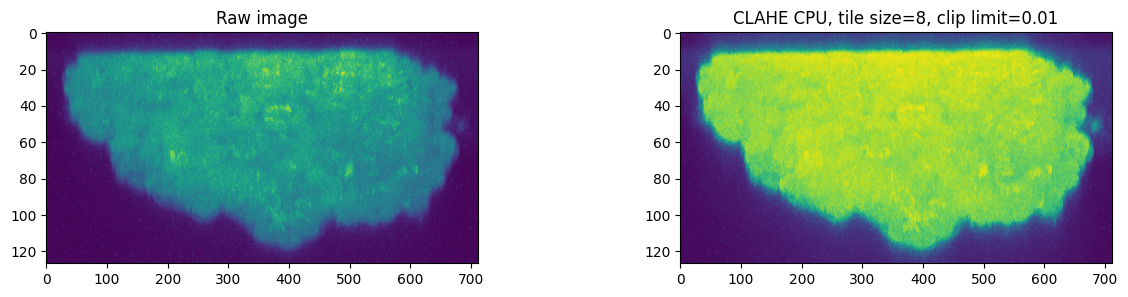

In [20]:
# visualize last processed image
fig,axs=plt.subplots(1,2,figsize=(15,3))
axs[0].imshow(np.max(img_np,axis=1),aspect=3)
axs[1].imshow(np.max(result_np,axis=1),aspect=3)
axs[0].set_title('Raw image')
axs[1].set_title('CLAHE CPU, tile size='+str(tile_size)+', clip limit='+str(0.01))

## Result comparison

In [21]:
raw = [io.imread(image) for image in sorted(glob.glob('*raw.tif'))]
clahe_cpu = [io.imread(image) for image in sorted(glob.glob('*cpu.tif'))]
clahe_gpu = [io.imread(image) for image in sorted(glob.glob('*gpu.tif'))]
imgs = [raw, clahe_cpu, clahe_gpu]
imgs_names = ['raw', 'clahe_cpu', 'clahe_gpu']
cols = ['k' , 'r' , 'b']

Text(0, 0.5, 'log(Proportion of pixels)')

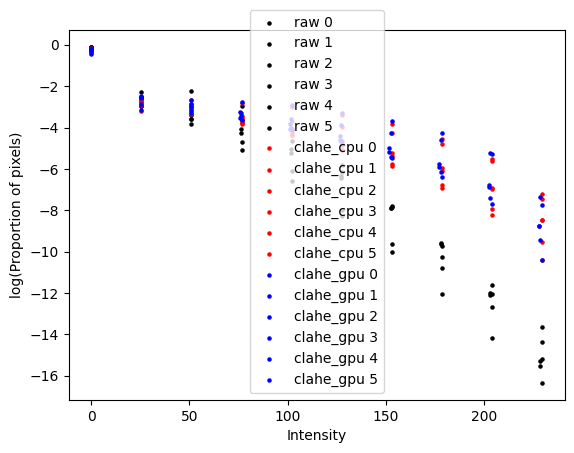

In [22]:
for i in range(len(imgs)):
    for j in range(len(imgs[i])):
        vals , bins =np.histogram(imgs[i][j])
        plt.scatter(bins[:-1], np.log(vals/np.sum(vals)), color=cols[i], s=5, label = imgs_names[i]+' '+str(j))
        
plt.legend()
plt.xlabel('Intensity')
plt.ylabel('log(Proportion of pixels)')

Normally the disributions for GPU and CPU processed CLAHE should be similar and enrched in higher intensity values.

## Performance comparison

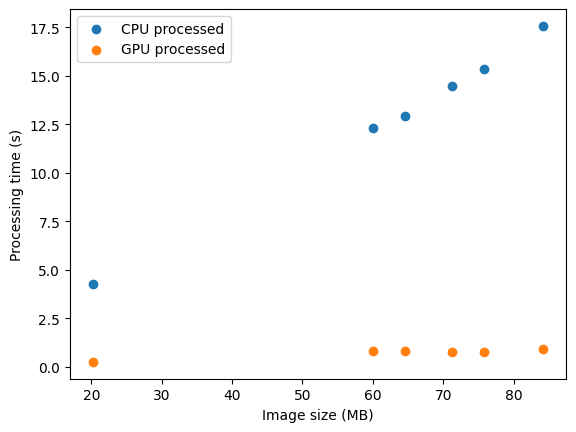

In [23]:
plt.scatter(np.array(img_size)/10**6,time_cpu,label='CPU processed')
plt.scatter(np.array(img_size)/10**6,time_gpu,label='GPU processed')
plt.xlabel('Image size (MB)')
plt.ylabel('Processing time (s)')
plt.legend()